In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scanpy as sc

In [2]:
# path for decipher if not installed
import sys
sys.path.append("../")
#############################

import decipher as dc
dc.pl.activate_journal_quality()

### Load the data

In [3]:
patient_name = "AML1"
adata = sc.read_h5ad(f"../reproducibility/{patient_name}.decipher.v2.h5ad")

In [4]:
palette_original = adata.uns["color_palette"]

# remove mep, ery and lympho
adata = adata[~adata.obs["cell_type"].isin(["mep", "ery", "lympho"])]

### Train Decipher

Epoch 31 | train elbo: 3480.93 | val ll: 3468.99:  31%|███       | 31/100 [04:07<09:09,  7.97s/it]2023-11-06 14:11:35,699 | INFO : Added `.obsm['decipher_v']`: the Decipher v space.
2023-11-06 14:11:35,700 | INFO : Added `.obsm['decipher_z']`: the Decipher z space.
2023-11-06 14:11:35,709 | INFO : Saving decipher model with run_id 2023-11-06-14-11-35-electrical-amber-vertex.


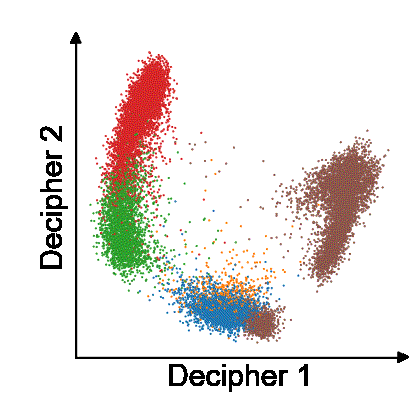

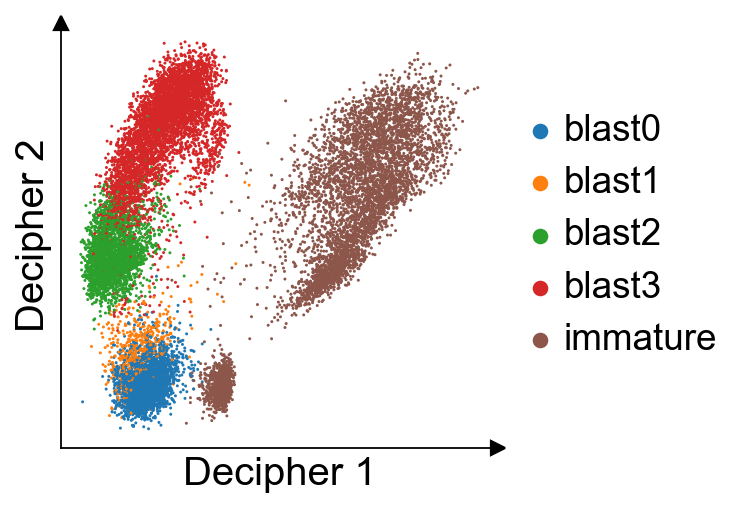

In [5]:
config = dc.tl.DecipherConfig() # optional Decipher config
d1, val1 = dc.tl.decipher_train(
    adata, config, plot_kwargs={"color": "cell_type", "palette": palette_original}, plot_every_k_epochs=5,
)

### Rotate and flip the learned latent space to align it with the mechanisms of interest
We would ideally want `Decipher 1` to capture blast progression, and `Decipher 2` to discriminate `Healthy` and the AML sample.

V5


2023-11-06 14:11:36,699 | INFO : Added `.obsm['decipher_v']`: the Decipher v space.
2023-11-06 14:11:36,700 | INFO : Added `.obsm['decipher_z']`: the Decipher z space.


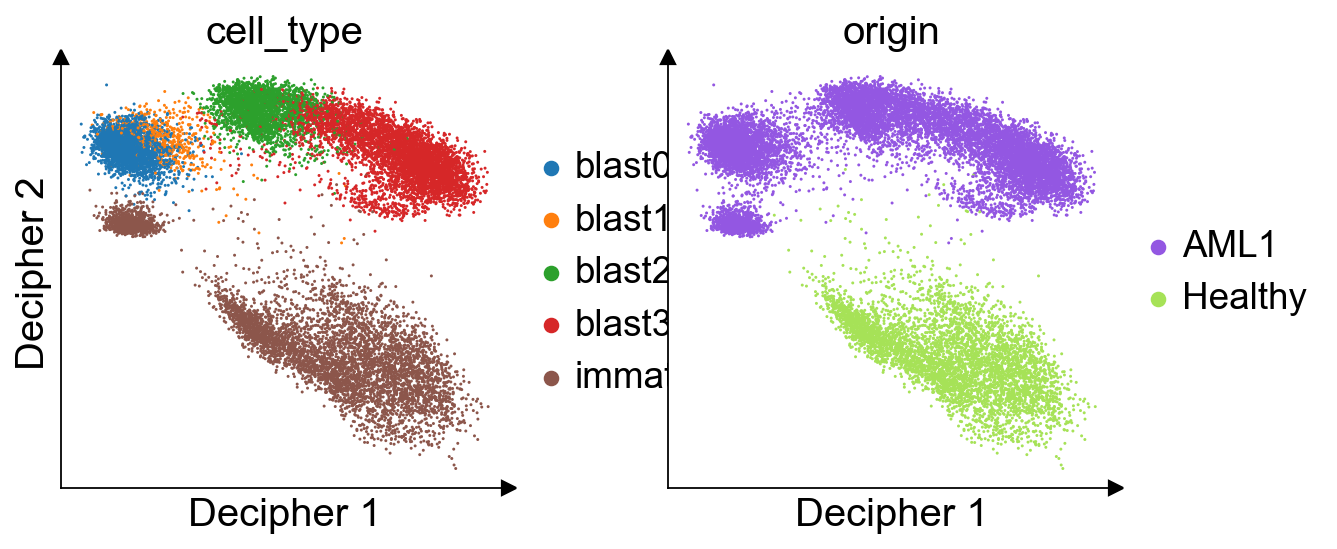

In [6]:
dc.tl.decipher_rotate_space(
    adata,
    v1_col="cell_type",
    v1_order=["blast0", "blast1", "blast2", "blast3"],
    v2_col="origin",
    v2_order=["Healthy", patient_name],
)
dc.pl.decipher(adata, ["cell_type", "origin"], palette=palette_original);

### We now cluster the cells using the `decipher_z` representation, and compute trajectories.

2023-11-06 14:11:37,487 | INFO : Clustering cells using scanpy Leiden algorithm.
2023-11-06 14:11:37,488 | INFO : Step 1: Computing neighbors with `sc.pp.neighbors`, with the representation decipher_z.
2023-11-06 14:15:22,057 | INFO : Step 2: Computing clusters with `sc.tl.leiden`, and resolution 1.0.
2023-11-06 14:15:23,973 | INFO : Added `.obs['decipher_clusters']`: the cluster labels.


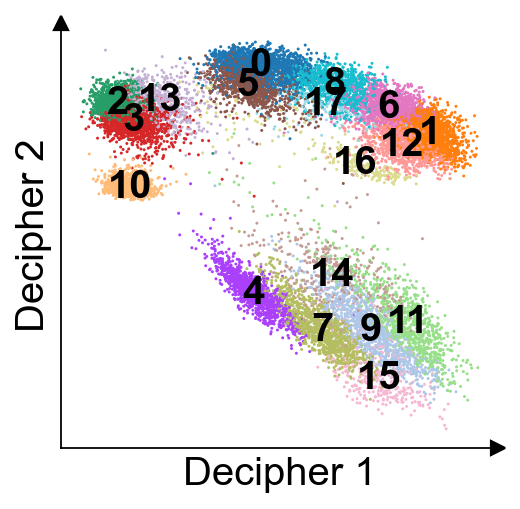

In [7]:
dc.tl.cell_clusters(adata)
dc.pl.decipher(adata, ["decipher_clusters"], legend_loc="on data");

2023-11-06 14:15:24,413 | INFO : Trajectory Healthy : ['4', '7', '9', '11'])
2023-11-06 14:15:24,417 | INFO : Added trajectory Healthy to `adata.uns['decipher']['trajectories']`.
2023-11-06 14:15:24,609 | INFO : Trajectory AML1 : ['10', '3', '13', '5', '0', '8', '6', '12'])
2023-11-06 14:15:24,615 | INFO : Added trajectory AML1 to `adata.uns['decipher']['trajectories']`.


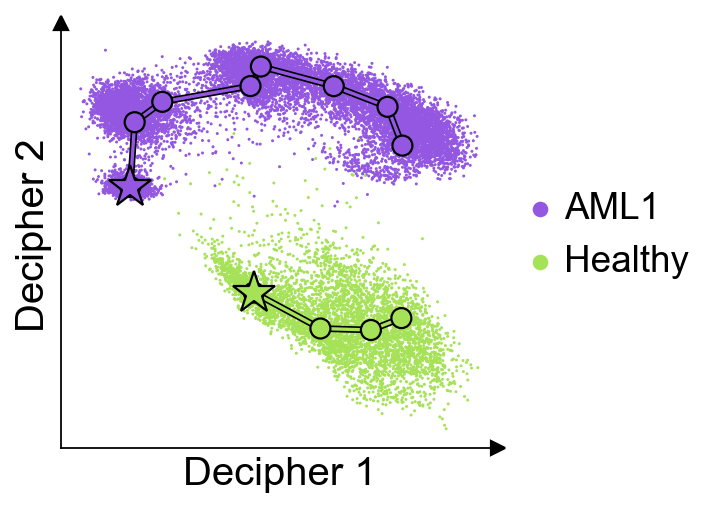

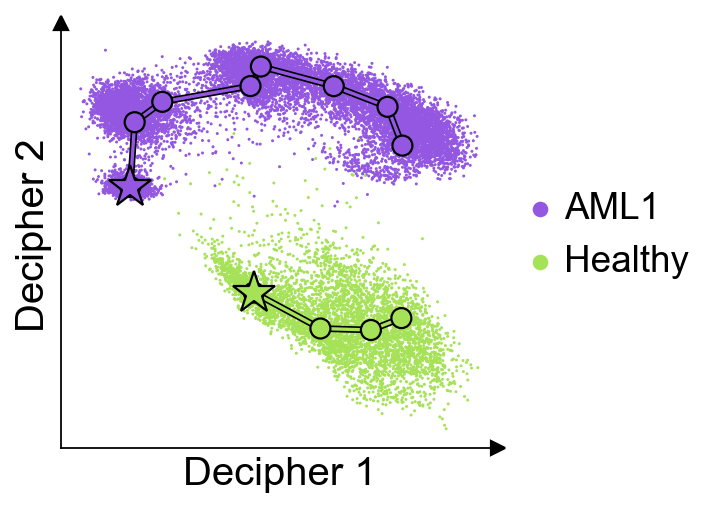

In [8]:
dc.tl.trajectories(
    adata,
    dc.tl.TConfig("Healthy", "AVP", "MPO", "origin", "Healthy"),
    dc.tl.TConfig(patient_name, "AVP", "CD68", "origin", patient_name),
)
dc.pl.trajectories(adata, "origin", palette=palette_original)

2023-11-06 14:15:25,122 | INFO : Added `.obs['decipher_time']`: the decipher time of each cell.


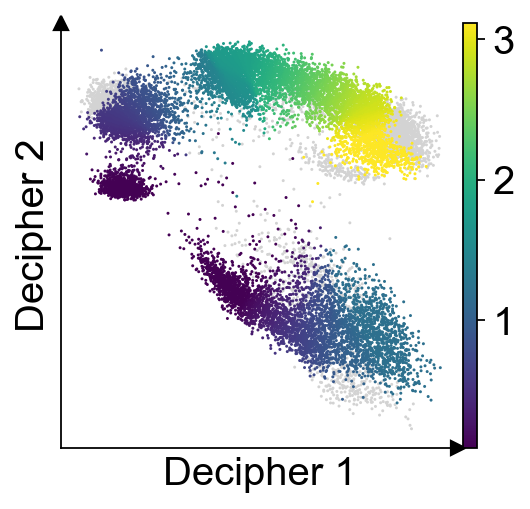

In [9]:
dc.tl.decipher_time(adata)
dc.pl.decipher_time(adata);

### Compute gene patterns

In [10]:
dc.tl.gene_patterns(adata)

V5


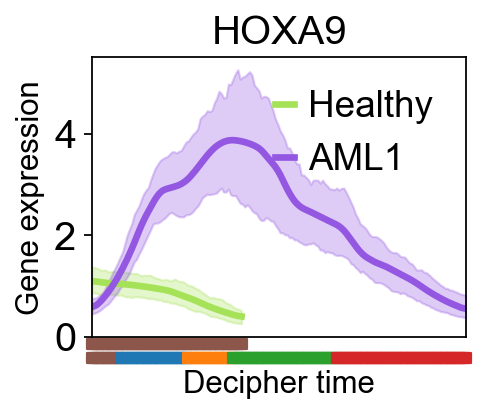

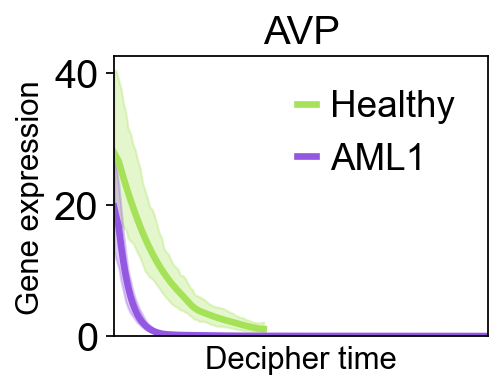

In [11]:
dc.pl.gene_patterns(adata, "HOXA9", palette=palette_original, cell_type_key="cell_type")
dc.pl.gene_patterns(adata, "AVP", palette=palette_original);

### Compute basis decomposition

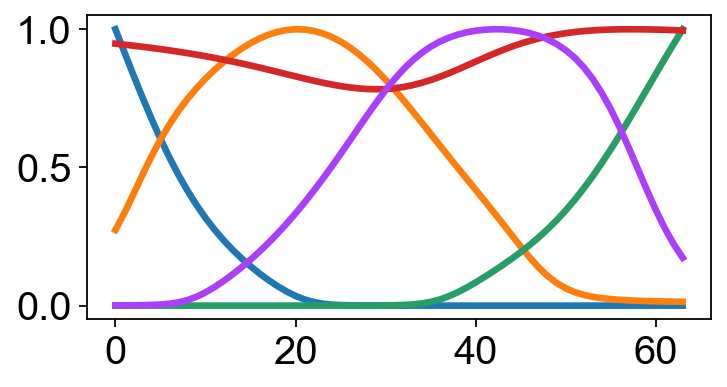

Loss: -786539.9 - Relative Error: 0.35%:  46%|████▌     | 4567/10000 [03:13<03:50, 23.55it/s]


In [12]:
training_losses = dc.tl.basis_decomposition(adata, seed=0);

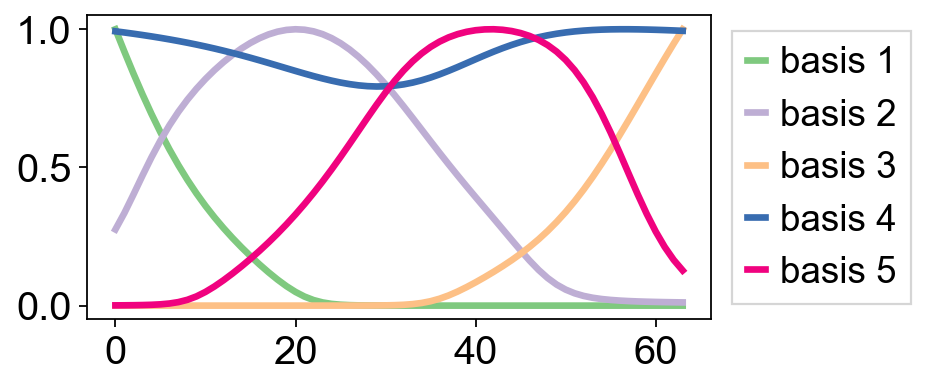

In [15]:
colors = [sns.color_palette("Accent")[i] for i in [0, 1, 2, 4, 5]]
dc.pl.basis(adata, colors=colors);

In [16]:
dc.tl.disruption_scores(adata)
adata.var[[c for c in adata.var if "decipher_disruption" in c]].sort_values(
    "decipher_disruption_combined", ascending=False
).head(10)

2023-11-06 15:05:33,468 | INFO : Added `.var['decipher_disruption_shape']`: shape disruption scores
2023-11-06 15:05:33,468 | INFO : Added `.var['decipher_disruption_scale']`: scale disruption scores
2023-11-06 15:05:33,469 | INFO : Added `.var['decipher_disruption_combined']`: combined disruption scores
2023-11-06 15:05:33,473 | INFO : Added `.uns['decipher']['disruption_scores']`: disruption scores
2023-11-06 15:05:33,474 | INFO : Added `.uns['decipher']['disruption_scores_samples']`: disruption scores probabilistic samples


decipher_disruption_shape  decipher_disruption_scale  \
index                                                            
DNTT                       0.376504                   6.720074   
C1QTNF4                    0.519964                   2.989532   
CXCL8                      0.761756                   6.727949   
ELANE                      0.447311                   4.638902   
PRTN3                      0.559028                   4.414043   
HLA-DRB5                   0.344512                   4.567631   
FAM213A                    0.680539                   1.745094   
CMTM8                      0.497220                   0.929708   
VPREB1                     0.451106                   4.503104   
POMC                       0.368308                   4.963417   

          decipher_disruption_combined  
index                                   
DNTT                         16.417521  
C1QTNF4                      13.807484  
CXCL8                        13.556322  
ELANE                        12.883770  
PRTN3                        12.554086  
HLA-DRB5                     12.347029  
FAM213A                      12.230834  
CMTM8                        12.219069  
VPREB1                       12.151206  
POMC                         12.113787

## Other figures

In [17]:
plt.rcParams["figure.figsize"] = [3,3]

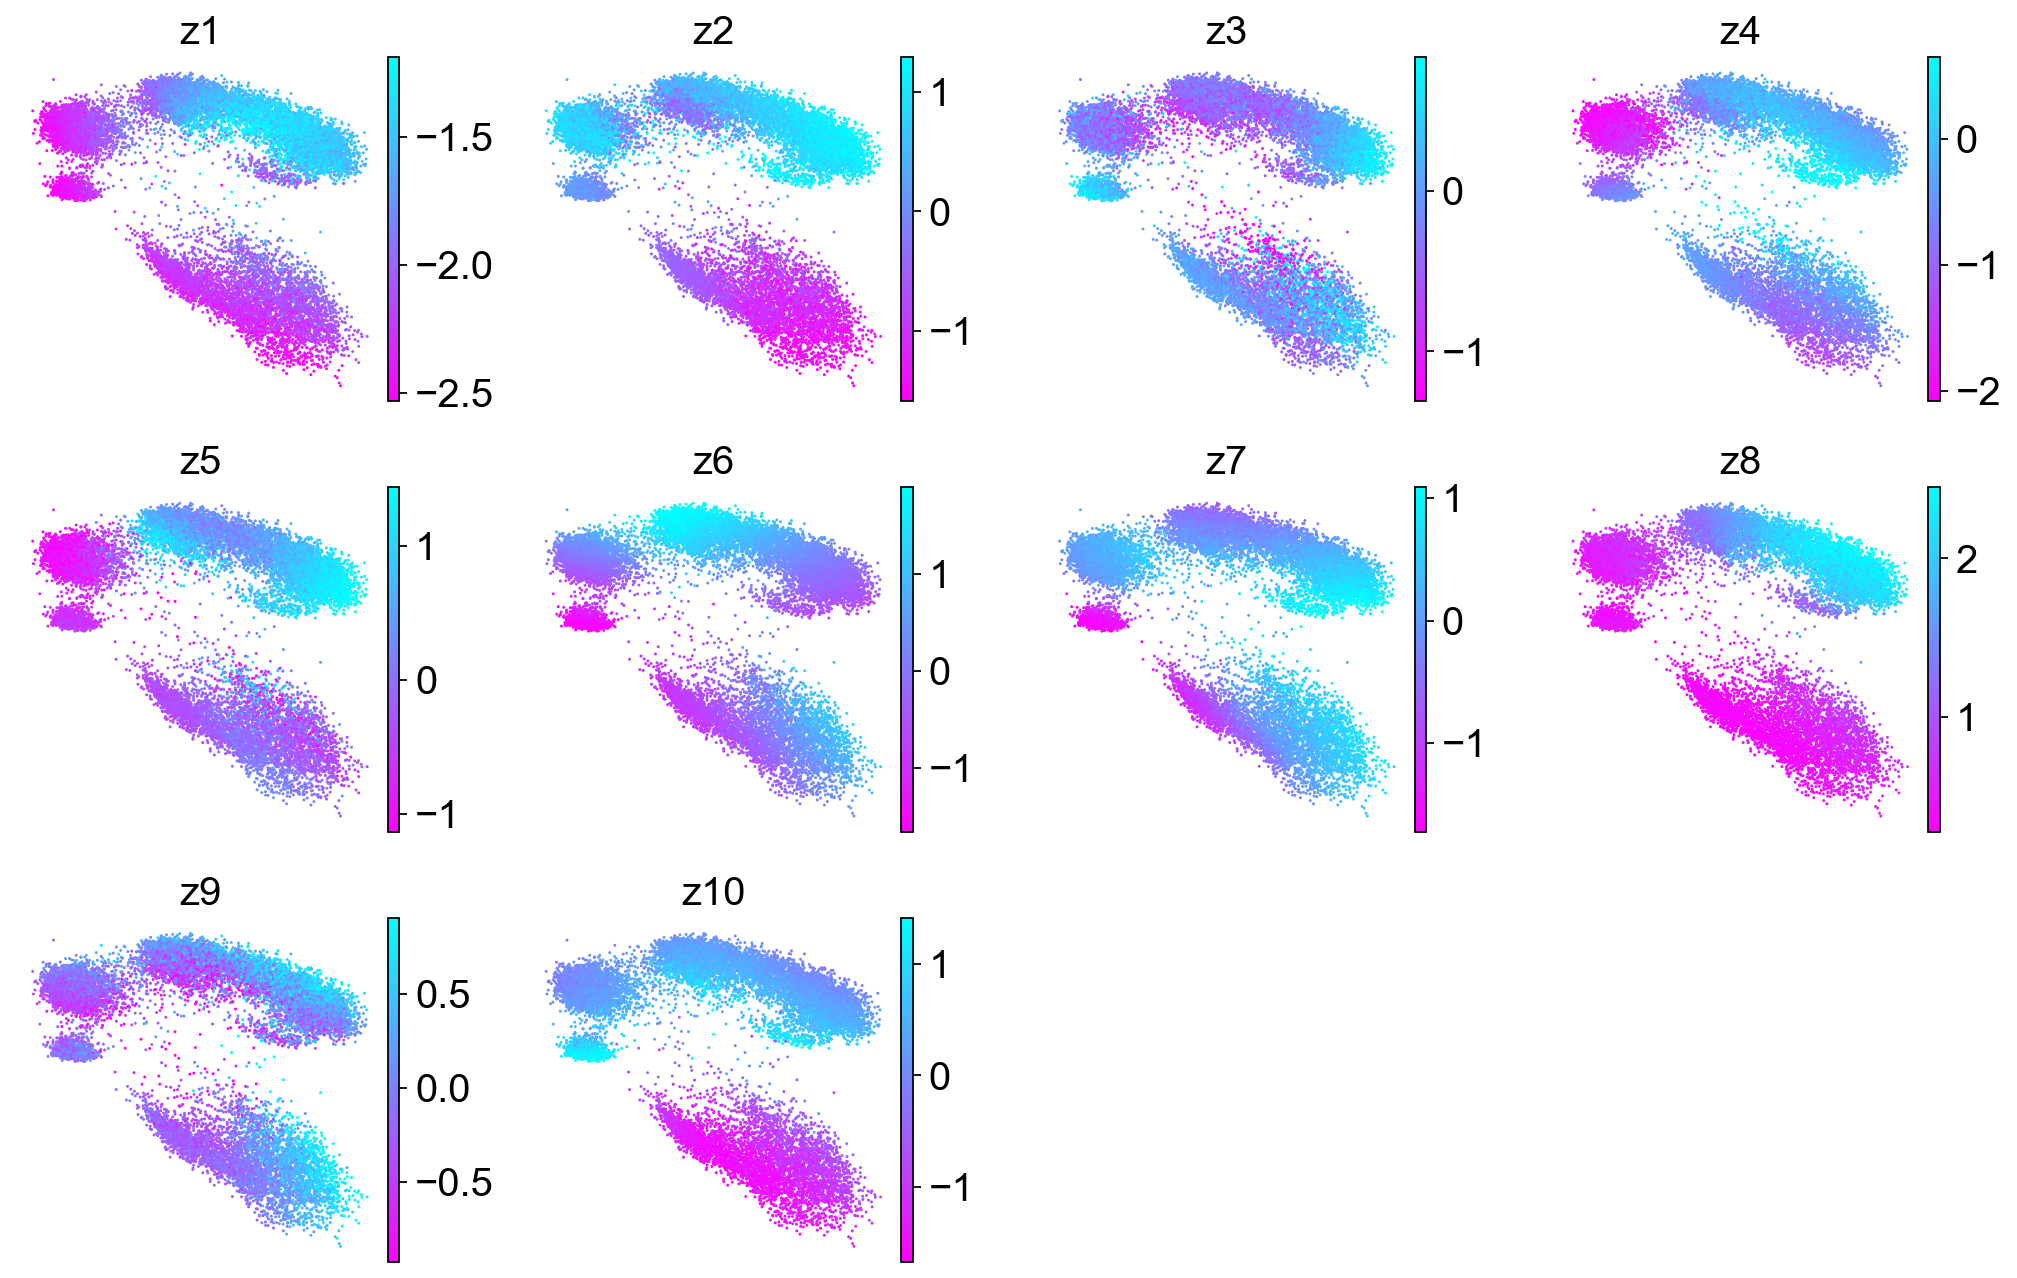

In [19]:
dc.pl.decipher_z(adata);

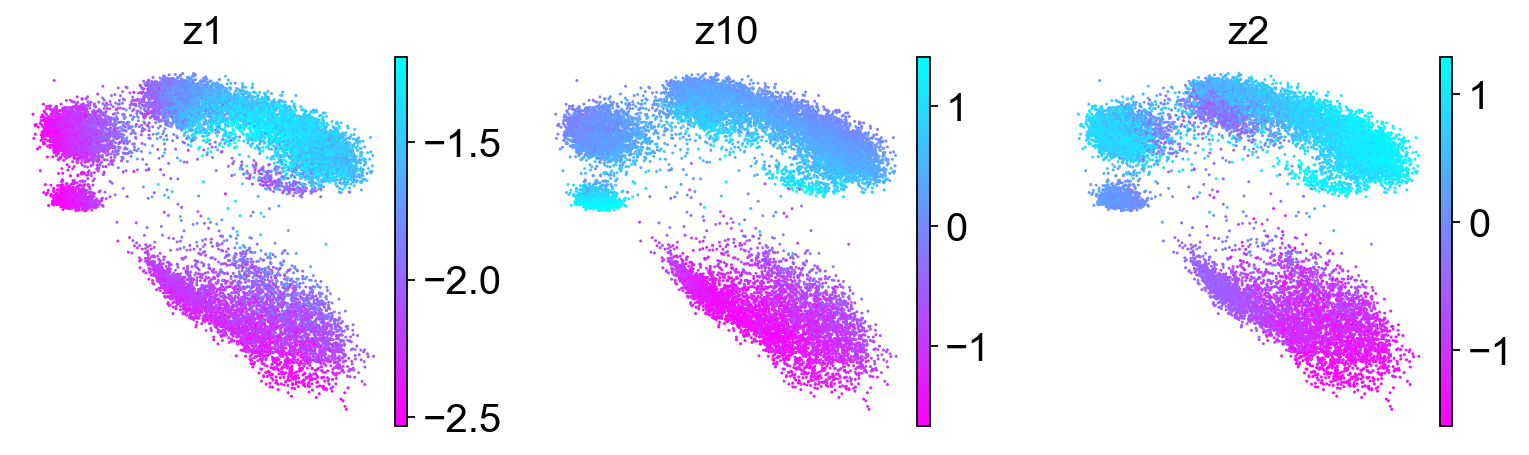

In [20]:
fig = dc.pl.decipher_z(adata, subset_of_zs=[1,10,2]);

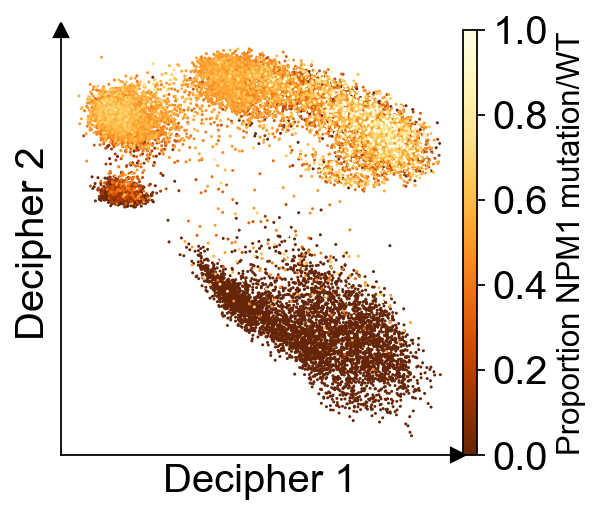

In [21]:
fig = dc.pl.decipher(adata, "NPM1 mutation vs wild type", cmap=sns.color_palette("YlOrBr_r", as_cmap=True, ))
fig.axes[0].collections[-1].colorbar.set_label("Proportion NPM1 mutation/WT", fontsize=14)


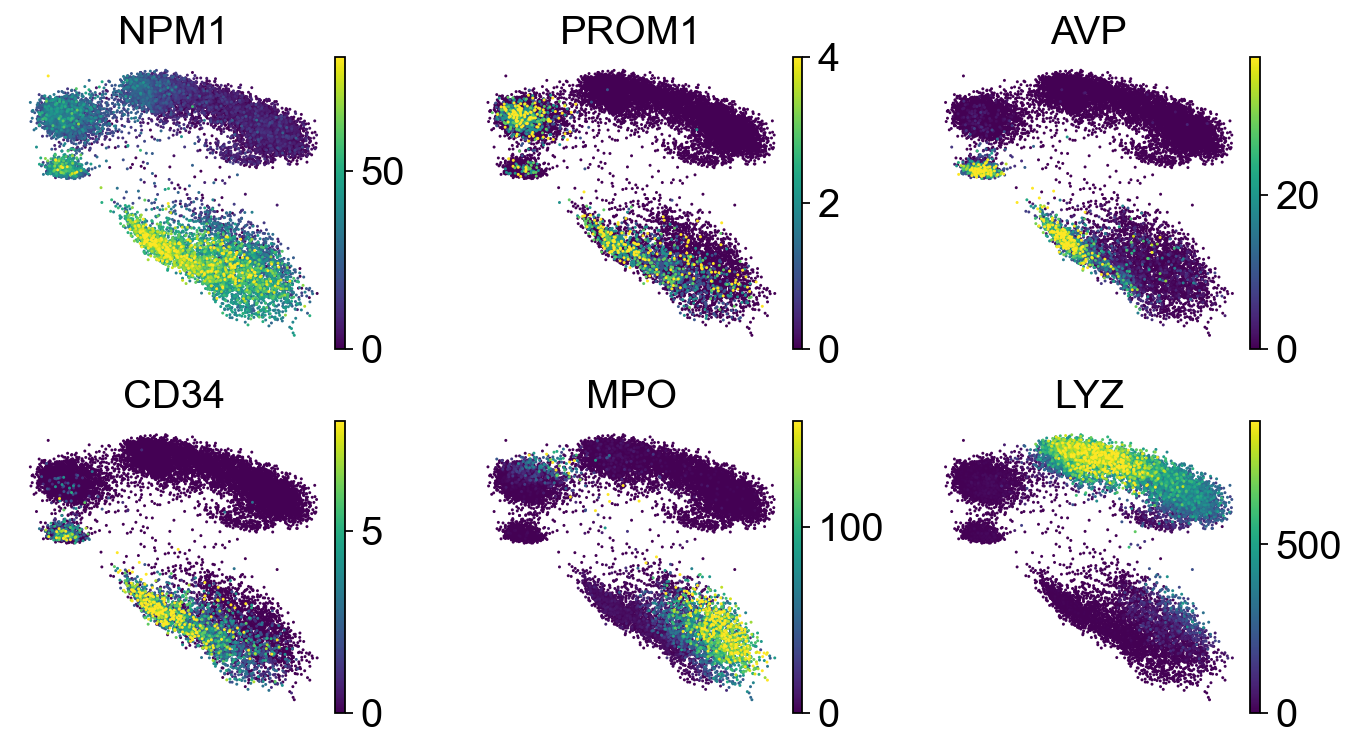

In [22]:
dc.pl.decipher(
    adata,
    ["NPM1", "PROM1", "AVP", "CD34", "MPO", "LYZ"],
    ncols=3,
    vmax=lambda x: np.quantile(x, 0.99),
    figsize=(2.5, 2.5),
    axis_type=None
);